Classification Model for Loan Approval Model

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Train Loan data.csv')

In [3]:
def object_numeric(df):
    df.drop('Loan_ID',axis = 1, inplace = True)
    object = [feature for feature in df.columns if df[feature].dtypes =='O' and feature not in 'Loan_Status']
    numeric = [feature for feature in df.columns if df[feature].dtypes != 'O' and feature not in 'Credit_History']
    
    return df, object, numeric

In [4]:
df, object, numeric = object_numeric(df)

In [5]:
def handle_missing(df):
    for i in range(df.shape[0]):
        if df.loc[i, 'Gender'] != ['Male', 'Female']:
            if df['Self_Employed'][i] == "Yes":
                df['Gender'][i] = "Male"
            
            else:
                df['Gender'][i] = "Female"
            
    df['Married'].fillna('Yes', inplace = True)
    
    df['Dependents'].fillna('3+', inplace = True)
    
    df['Self_Employed'].fillna('No', inplace = True)
    
    df['LoanAmount'].fillna(142.471735, inplace = True)
    
    df['Loan_Amount_Term'].fillna(342.876923, inplace = True)
    
    df['Credit_History'].fillna('1.0', inplace = True)
    
    return df

In [6]:
df = handle_missing(df)

<ipython-input-5-e6d14bea75f9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'][i] = "Female"
<ipython-input-5-e6d14bea75f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'][i] = "Male"


In [7]:
def outlier_detection(df):
    import matplotlib.pyplot as plt
    for value in numeric:
        fig, ax = plt.subplots(1,2, figsize=(8,6))
        fig = df[value].plot(kind = 'box', ax = ax[0])
        fig = df[value].plot(kind = 'hist', ax = ax[1])
        plt.xlabel(value)
        plt.show()

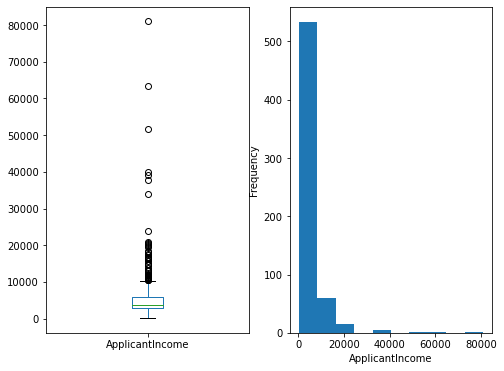

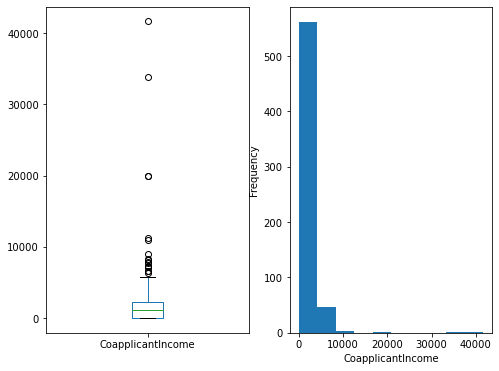

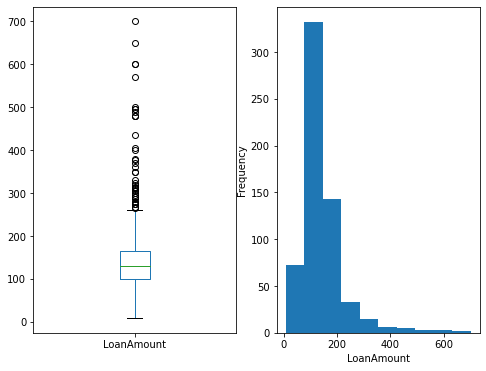

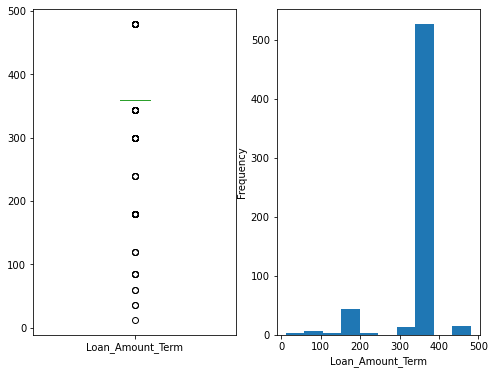

In [8]:
outlier_detection(df)

In [9]:
numeric

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [10]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Female,No,0,Graduate,No,5849,0.0,142.471735,360.0,1.0,Urban,Y
1,Female,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Female,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Female,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [11]:
def number_of_outlier_detection(df):
    for value in numeric:
        df1_q1 = df[value].quantile(0.25)
        df1_q3 = df[value].quantile(0.75)
        df1_iqr = df1_q3 - df1_q1
        low = df1_q1 - 1.5 * df1_iqr
        high = df1_q3 + 1.5 * df1_iqr
        for i in range(df.shape[0]):
            if df[value][i] < low:
                df[value][i] = df[value].mean()
                
            elif df[value][i] > high:
                df[value][i] = df[value].mean()
                
    return df

In [12]:
df = number_of_outlier_detection(df)

<ipython-input-11-7ff69d4f9877>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[value][i] = df[value].mean()
<ipython-input-11-7ff69d4f9877>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[value][i] = df[value].mean()


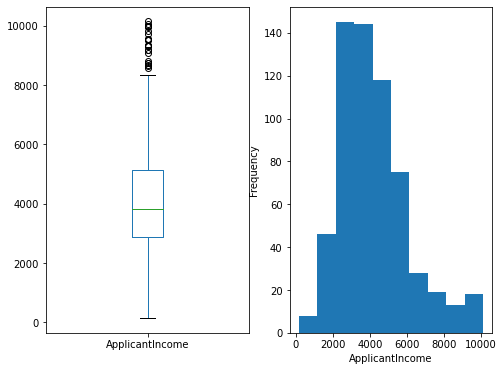

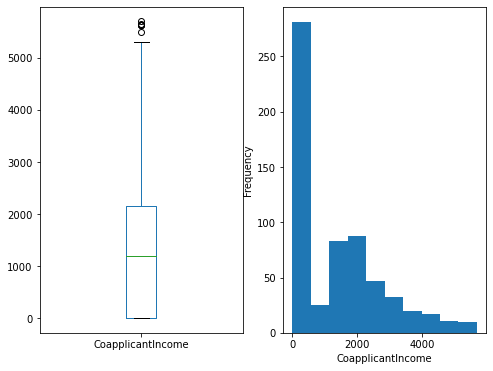

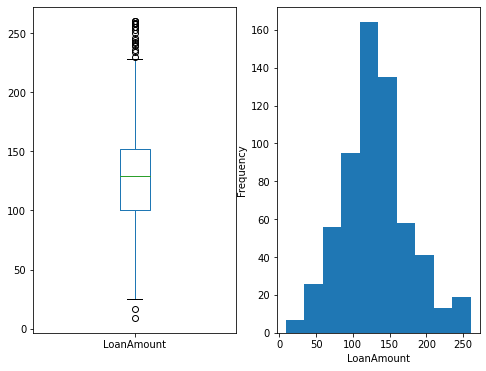

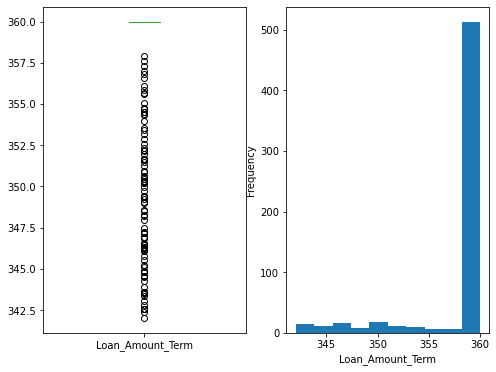

In [13]:
outlier_detection(df)

In [14]:
def feature_engineering(df):
    from sklearn.preprocessing import LabelEncoder
    for feature in object:
        df[feature] = LabelEncoder().fit_transform(df[feature])
        
    from sklearn.preprocessing import OneHotEncoder
    final_encoded = []
    for feature in object:
        encoded_data = OneHotEncoder().fit_transform(df[feature].values.reshape(-1,1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n+1)]
        encoded_df = pd.DataFrame(encoded_data, columns = cols)
        encoded_df.index = df.index
        final_encoded.append(encoded_df)
    final_data = pd.concat([df, *final_encoded], axis = 1)
    
    return final_data

In [15]:
final_data = feature_engineering(df)

In [16]:
final_data.shape

(614, 27)

In [17]:
final_data.drop(object, axis = 1, inplace = True)

In [18]:
def data_segregation(df):
    
    x = df.drop('Loan_Status', axis = 1)
    y = df.iloc[:, -1]
    
    return x, y

In [19]:
x, y = data_segregation(final_data)

In [20]:
def best_feature_selection(x,y, df):
    
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    
    best_features = SelectKBest(score_func = chi2, k = 'all')
    
    fit = best_features.fit(x, y)
    
    df_scores = pd.DataFrame(fit.scores_)
    dfcol = pd.DataFrame(x.columns)
    
    feature_score = pd.concat([df_scores, dfcol], axis = 1)
    feature_score.columns = ['score', 'variable']
    
    final = feature_score.groupby('variable').sum().sort_values(by = 'score', ascending = False).head(15).index
    
    new_data = df[final]
    
    return new_data, final

In [21]:
new_data, final = best_feature_selection(x, y, final_data)

In [22]:
new_data.shape

(614, 15)

In [23]:
def scaling(new_data):
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    new_data = sc.fit_transform(new_data)
    
    return new_data

In [24]:
new_data = scaling(new_data)

In [25]:
y.value_counts()

0.0    412
1.0    202
Name: Property_Area_3, dtype: int64

In [26]:
def data_balance(new_data, y):
    from imblearn.over_sampling import RandomOverSampler
    os = RandomOverSampler(0.6)
    xover, yover = os.fit_resample(new_data, y)
    
    return xover, yover

In [27]:
xover, yover = data_balance(new_data, y)

C:\Users\Yogesh\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.6 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [34]:
yover.value_counts()

0.0    412
1.0    247
Name: Property_Area_3, dtype: int64

In [28]:
def over_sampling_values(y, yover):
    
    from collections import Counter
    print('Before sampling:{}'.format(Counter(y)))
    print('After sampling:{}'.format(Counter(yover)))

In [29]:
over_sampling_values(y, yover)

Before sampling:Counter({0.0: 412, 1.0: 202})
After sampling:Counter({0.0: 412, 1.0: 247})


In [30]:
def classification_model(xover, yover):
    
    from sklearn.linear_model import LogisticRegression
    
    classifier = LogisticRegression()
    
    from sklearn.model_selection import train_test_split
    xtrain, xtest, ytrain, ytest = train_test_split(xover, yover,stratify = yover, test_size = 0.2, random_state = 0)
    
    classifier.fit(xtrain, ytrain)
    
    ypred = classifier.predict(xtest)
    
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
    
    print("Confusion Matrix{}".format(confusion_matrix(ytest, ypred)))
    print("Classification Report {}".format(classification_report(ytest, ypred)))
    print("Accuracy Score {}".format(accuracy_score(ytest, ypred)))

In [31]:
classification_model(xover, yover)

Confusion Matrix[[83  0]
 [ 0 49]]
Classification Report               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        83
         1.0       1.00      1.00      1.00        49

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Accuracy Score 1.0


In [32]:
def xgboost_classifier(xover, yover):
    from xgboost import XGBClassifier
    classifier = XGBClassifier()

    from sklearn.model_selection import train_test_split
    xtrain, xtest, ytrain, ytest = train_test_split(xover, yover,stratify = yover, test_size = 0.2, random_state = 0)
    
    classifier.fit(xtrain, ytrain)
    
    ypred = classifier.predict(xtest)
    
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
    
    print("Confusion Matrix{}".format(confusion_matrix(ytest, ypred)))
    print("Classification Report {}".format(classification_report(ytest, ypred)))
    print("Accuracy Score {}".format(accuracy_score(ytest, ypred)))
    

In [33]:
xgboost_classifier(xover, yover)

[21:55:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix[[83  0]
 [ 0 49]]
Classification Report               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        83
         1.0       1.00      1.00      1.00        49

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Accuracy Score 1.0


C:\Users\Yogesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [35]:
classification_model(new_data, y)

Confusion Matrix[[83  0]
 [ 0 40]]
Classification Report               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        83
         1.0       1.00      1.00      1.00        40

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy Score 1.0


In [36]:
xgboost_classifier(new_data, y)

[22:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix[[83  0]
 [ 0 40]]
Classification Report               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        83
         1.0       1.00      1.00      1.00        40

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy Score 1.0


C:\Users\Yogesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
